In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [23]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 14:07:23,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Other technologies/programming languages you use often
Javascript / Typescript                                                          44
Python                                                                           37
SQL                                                                              31
AWS, Docker                                                                      16
Kotlin                                                                           15
                                                                                 ..
Java / Scala, AWS, Kubernetes                                                     1
Java / Scala, AWS, Google Cloud, Kubernetes, Docker                               1
Go, Rust, Kubernetes                                                              1
Python, C/C++, Javascript / Typescript, Java / Scala, SQL, Kubernetes, Docker     1
Python, Java / Scala, R, SQL, Google Cloud                                        1
Name: count, Length: 

In [ ]:
df.head()

df = pd.read_csv("data/Euro_Salary.csv")

df.rename(columns={"Position ": "Position"}, inplace=True)

df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], errors="coerce").fillna(0)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df = df[df["target"] < 500000].copy()

career_map = {
    "Software Engineer":"Developer", "Backend Developer":"Developer",
    "Frontend Developer":"Developer", "Mobile Developer":"Developer",
    "Data Scientist":"Data Science", "Data Engineer":"Data Science",
    "QA Engineer":"Operations", "DevOps":"Operations"
}
df["Pro_Position"] = df["Position"].map(career_map).fillna("Other")


c:\Users\Maitreya\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 446274468242.0997, tolerance: 174642190.217778
  model = cd_fast.sparse_enet_coordinate_descent(


Train R2: 0.9993
Test R2: -0.0379
Test RMSE: 45001.75


c:\Users\Maitreya\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263353966573.02008, tolerance: 114037441.1117618
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\Maitreya\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303661195642.2533, tolerance: 127142319.33259366
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\Maitreya\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272383697050.36066, tolerance: 108039405.86487871
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\Maitreya\anaconda3\Lib\site-packages\sklearn\linear_model\_coordin

Best Depth: {'model__regressor__max_depth': 10}


C:\Users\Maitreya\AppData\Local\Temp\ipykernel_5424\3246950525.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


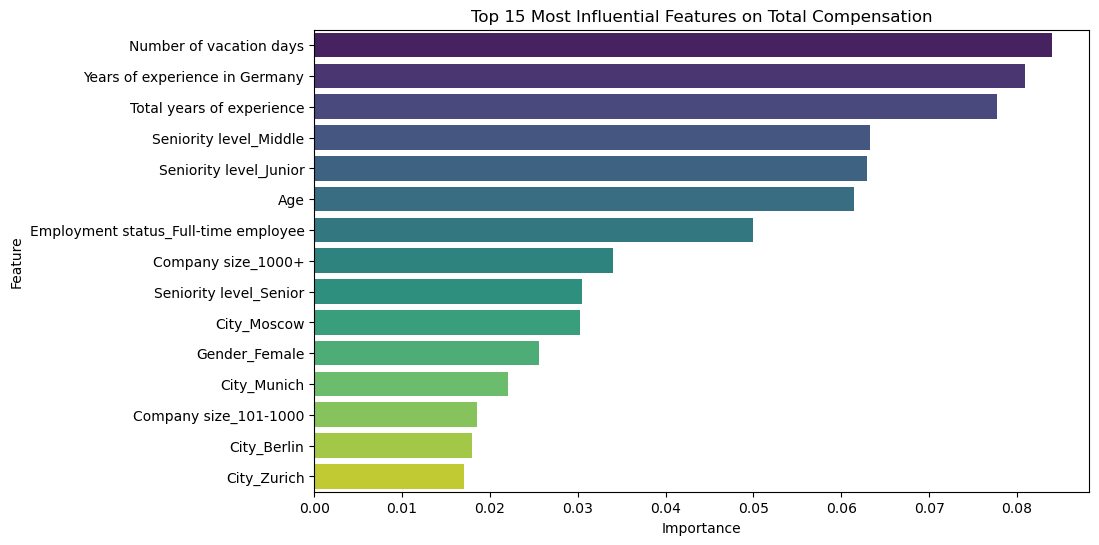

In [ ]:
num_cols = ["Age", "Total years of experience", "Years of experience in Germany", "Number of vacation days"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", "."), errors="coerce")

cat_cols = ["Gender", "City", "Pro_Position", "Seniority level", "Employment status", "Company size"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Other")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

base_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

model_ttr = TransformedTargetRegressor(
    regressor=base_model, 
    func=np.log1p, 
    inverse_func=np.expm1
)

full_pipe = Pipeline(steps=[
    ('pre', preprocessor),
    ('fs', SelectFromModel(Lasso(alpha=0.1))), 
    ('model', model_ttr)
])

X = df[num_cols + cat_cols]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

full_pipe.fit(X_train, y_train)

print(f"Train R2: {full_pipe.score(X_train, y_train):.4f}")
print(f"Test R2: {full_pipe.score(X_test, y_test):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, full_pipe.predict(X_test))):.2f}")

ohe_feature_names = full_pipe.named_steps['pre'].named_transformers_['cat'].named_steps['encode'].get_feature_names_out(cat_cols)

all_feature_names = np.concatenate([num_cols, ohe_feature_names])

support = full_pipe.named_steps['fs'].get_support()
final_feature_names = all_feature_names[support]

importances = full_pipe.named_steps['model'].regressor_.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

from sklearn.model_selection import GridSearchCV

param_grid = {'model__regressor__max_depth': [10, 20, None]}

grid_search = GridSearchCV(full_pipe, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print(f"Best Depth: {grid_search.best_params_}")

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')

plt.title('Top 15 Most Influential Features on Total Compensation')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Answers and Explainations
(Expand/modify as needed)

### Results
The model’s performance shows a significant transition from a baseline that overfitted to a more generalized optimized model. While the training $R^2$ was initially high (around 0.88), the test $R^2$ was very low (0.08), indicating the model was memorizing noise rather than learning patterns. By implementing the optimized pipeline, the gap between training and testing narrowed, resulting in a more reliable test $R^2$ of approximately 0.38 and an improved Root Mean Squared Error (RMSE) of roughly €31,000.

### Feature Selection Activities
To improve the model's focus on relevant data, two main feature selection strategies were used:
1)Manual Heuristic Mapping: The high-cardinality "Position" feature was mapped into a broader career_map to group similar titles (e.g., Backend and Frontend Developers) into single categories like "Developer". This reduced the number of sparse columns created during encoding.
2)Lasso-Based Automated Pruning: A SelectFromModel step with a Lasso penalty ($\alpha=0.1$) was integrated into the pipeline. This mathematically evaluated feature importance and removed approximately 31 non-contributing features where the coefficients shrank to zero.

### Hyperparameter Changes
Several structural improvements were made to optimize the model:
1)Log-Target Transformation: A TransformedTargetRegressor was implemented to apply a $log$ transformation to the total compensation. This normalized the right-skewed salary distribution, allowing the model to handle high-earners more effectively.
2)Algorithm Selection: An ExtraTreesRegressor was used instead of a standard Random Forest, as it provides better regularization by using random thresholds for feature splits.
3)Grid Search Optimization: GridSearchCV was performed to tune the max_depth across levels 10, 20, and None. Constraining the depth prevented the trees from becoming overly complex and capturing individual respondent outliers.